Read the data into a Pandas dataframe, then use the to_datetime function to ensure the time series is a datetime type.

In [1]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

This notebook is compatible with Azure ML SDK version 1.35.0 or later.

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.34.0 of the Azure ML SDK


In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = "automl-forecasting-allenergydemandbycountries"

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,1a934169-b0e2-4c4b-bb4f-53da0e05fc05
Workspace,energyall
Resource Group,energypredict
Location,eastus2
Run History Name,automl-forecasting-allenergydemandbycountries


If the AmlCompute with that name is already in your workspace this code will skip the creation process. As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "energy-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_DS12_V2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


We will use energy consumption data from UN DataSet for model training. The data is stored in a tabular format and includes energy consumption per year.

With Azure Machine Learning datasets you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. Below, we will upload the datatset and create a tabular dataset to be used training and prediction.

Let's set up what we know about the dataset.

Target column is what we want to forecast.
Time column is the time axis along which to predict.

The other columns are implicitly designated as features.

Chunking: subdividing datasets into smaller parts

In [5]:
chunk_size=50000
batch_no=1
for chunk in pd.read_csv('all_energy_statistics.csv',chunksize=chunk_size):
    chunk.to_csv('chunk'+str(batch_no)+'.csv',index=False)
    batch_no+=1

Importing a single chunk file into pandas dataframe:

In [6]:
df1 = pd.read_csv('chunk1.csv')
df1.head()

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates


Using sample() method in pandas to shuffle dataset for randomization prior to creating model. use frac=0.5 for 50% of rows.

In [7]:
df2 = df1.sample(frac=1)

In [8]:
import pandas as pd
df = pd.read_csv("all_energy_statistics.csv")
df.head(10)

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates
5,Belgium,Additives and Oxygenates - Exports,2011,"Metric tons, thousand",25.0,NaN,additives_and_oxygenates
6,Belgium,Additives and Oxygenates - Exports,2010,"Metric tons, thousand",22.0,NaN,additives_and_oxygenates
7,Belgium,Additives and Oxygenates - Exports,2009,"Metric tons, thousand",45.0,NaN,additives_and_oxygenates
8,Czechia,Additives and Oxygenates - Exports,1998,"Metric tons, thousand",1.0,NaN,additives_and_oxygenates
9,Czechia,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",7.0,NaN,additives_and_oxygenates


In [9]:
df2 = df.sample(frac=0.000001)

In [10]:
time_column_name = "commodity_transaction"
time_column_name = "year"

In [11]:
from azureml.core import Workspace, Datastore, Dataset

datastore_name = 'unallenergy'

# get existing workspace
workspace = Workspace.from_config()
    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)

# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'all_energy_statistics.csv')]

weather_ds = Dataset.Tabular.from_delimited_files(path=datastore_paths)

In [12]:
datastore

{
  "name": "unallenergy",
  "container_name": "azureml",
  "account_name": "energyall1351863142",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [13]:
sorted(df['country_or_area'].unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctic Fisheries',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia (Plur. State of)',
 'Bonaire, St Eustatius, Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Rep.',
 'Chad',
 'Chile',
 'China',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'Colombia',
 'Commonwealth of Independent States (CIS)',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Czechoslovakia (former)',
 "Côte d'Ivoire",
 'Dem. Rep. of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Domin

In [14]:
for i in df.unit.unique():
    print(i)
    print('\n')
    print(df[df['unit']==i]['commodity_transaction'].unique())
    print('\n')

Metric tons,  thousand


['Additives and Oxygenates - Exports' 'Additives and Oxygenates - Imports'
 'Additives and Oxygenates - Production' ...
 'White spirit and special boiling point industrial spirits - Transfers and recycled products'
 'White spirit and special boiling point industrial spirits - Transformation'
 'White spirit and special boiling point industrial spirits - Transformation in petrochemical plants']


Terajoules


['Animal waste - Consumption by commerce and public services'
 'Animal waste - Consumption by food and tobacco '
 'Animal waste - Consumption by households'
 'Animal waste - Consumption by manufacturing, construction and non-fuel industry'
 'Animal waste - Consumption by non-metallic minerals '
 'Animal waste - Consumption by other'
 'Animal waste - Consumption by other manuf., const. and non-fuel min. ind.'
 'Animal waste - Consumption in agriculture, forestry and fishing'
 'Animal waste - Consumption not elsewhere specified (industry)'
 'Animal waste - Con

['Electricity generating capacity - From other sources - Autoproducers'
 'Electricity generating capacity - From other sources - Main activity producers'
 'Electricity generating capacity - From other sources - Total'
 'Electricity generating capacity - Pumped hydro - Autoproducers'
 'Electricity generating capacity - Pumped hydro - Main activity producers'
 'Electricity generating capacity - Pumped hydro - Total'
 'Electricity generating capacity - Solar PV - Autoproducers'
 'Electricity generating capacity - Solar PV - Main activity producers'
 'Electricity generating capacity - Solar PV - Total'
 'Electricity generating capacity - Solar Thermal - Autoproducers'
 'Electricity generating capacity - Solar Thermal - Main activity producers'
 'Electricity generating capacity - Solar Thermal - Total'
 'Electricity - net installed capacity of electric power plants, public combustible fuels'
 'Electricity - net installed capacity of electric power plants, public geothermal'
 'Electricity - 

In [15]:
# Find  the shape, features and unique values
print("Number of rows and columns are:", df.shape)
print("List of countries and Area are: {}".format(df.country_or_area.unique()))

Number of rows and columns are: (1189482, 7)
List of countries and Area are: ['Austria' 'Belgium' 'Czechia' 'Finland' 'France' 'Greece' 'Hungary'
 'Italy' 'Korea, Republic of' 'Netherlands' 'Romania' 'Serbia' 'Slovakia'
 'Ukraine' 'United Kingdom' 'United States' 'Brunei Darussalam' 'Bulgaria'
 'Canada' 'Chile' 'Croatia' 'Iran (Islamic Rep. of)' 'Jordan' 'Lithuania'
 'Mexico' 'Oman' 'Other Asia' 'Poland' 'Portugal' 'Spain' 'Sweden'
 'Switzerland' 'T.F.Yug.Rep. Macedonia' 'Turkey' 'Uzbekistan' 'Argentina'
 'Colombia' 'Germany' 'Norway' 'Australia' 'China, Macao SAR' 'Japan'
 'Denmark' 'Ireland' 'Philippines' 'Bangladesh' 'Eritrea' 'Ethiopia'
 'Lesotho' 'Nepal' 'Niger' 'Pakistan' 'Serbia and Montenegro' 'Tunisia'
 'Botswana' 'Georgia' 'Republic of Moldova' 'Peru' 'South Africa'
 'Iceland' 'Latvia' 'Luxembourg' 'Cuba' 'Kyrgyzstan' 'Singapore'
 'Thailand' 'United Arab Emirates' 'Uruguay' 'Armenia' 'Fiji'
 "Korea, Dem.Ppl's.Rep." 'Russian Federation' 'Swaziland' 'Zimbabwe'
 'Afghanistan' 'A

In [16]:
# To find details about the data from the imported file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189482 entries, 0 to 1189481
Data columns (total 7 columns):
country_or_area          1189482 non-null object
commodity_transaction    1189482 non-null object
year                     1189482 non-null int64
unit                     1189482 non-null object
quantity                 1189482 non-null float64
quantity_footnotes       163946 non-null float64
category                 1189482 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 63.5+ MB


In [17]:
#To check for the unique values for 'country_or_area' column
len(df['country_or_area'].unique())

243

In [18]:
#To check for the unique values for 'year' column
len(df['year'].unique())

25

In [19]:
#checking for the unique values for 'category' column
len(df['category'].unique())

71

In [20]:
# To find the missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['Count', '%']
missing.sort_values(by='Count', ascending=False)

,Count,%
quantity_footnotes,1025536,86.217026
country_or_area,0,0.000000
commodity_transaction,0,0.000000
year,0,0.000000
unit,0,0.000000
quantity,0,0.000000
category,0,0.000000


In [21]:
# Since quantity_footnotes is missing lots of value, drop it from the analysis
df1 = df.drop(['quantity_footnotes'], axis=1)
df1.columns

Index(['country_or_area', 'commodity_transaction', 'year', 'unit', 'quantity',
       'category'],
      dtype='object')

In [22]:
# To convert all the names in this & other column to lower case
df1['country_or_area'] = df1['country_or_area'].str.lower()
df1['commodity_transaction'] = df1['commodity_transaction'].str.lower()
df1['unit'] = df1['unit'].str.lower()
df1['category'] = df1['category'].str.lower()
df1.head()

,country_or_area,commodity_transaction,year,unit,quantity,category
0,austria,additives and oxygenates - exports,1996,"metric tons, thousand",5.0,additives_and_oxygenates
1,austria,additives and oxygenates - exports,1995,"metric tons, thousand",17.0,additives_and_oxygenates
2,belgium,additives and oxygenates - exports,2014,"metric tons, thousand",0.0,additives_and_oxygenates
3,belgium,additives and oxygenates - exports,2013,"metric tons, thousand",0.0,additives_and_oxygenates
4,belgium,additives and oxygenates - exports,2012,"metric tons, thousand",35.0,additives_and_oxygenates


In [23]:
# Simplifying the column names by renaming it
df1.columns = ['country', 'commodity', 'year', 'unit', 'quantity', 'category']
df1.head()

,country,commodity,year,unit,quantity,category
0,austria,additives and oxygenates - exports,1996,"metric tons, thousand",5.0,additives_and_oxygenates
1,austria,additives and oxygenates - exports,1995,"metric tons, thousand",17.0,additives_and_oxygenates
2,belgium,additives and oxygenates - exports,2014,"metric tons, thousand",0.0,additives_and_oxygenates
3,belgium,additives and oxygenates - exports,2013,"metric tons, thousand",0.0,additives_and_oxygenates
4,belgium,additives and oxygenates - exports,2012,"metric tons, thousand",35.0,additives_and_oxygenates


In [24]:
# To explore the category
df1['category'].unique()

array(['additives_and_oxygenates', 'animal_waste', 'anthracite',
       'aviation_gasoline', 'bagasse', 'biodiesel', 'biogases',
       'biogasoline', 'bitumen', 'black_liquor', 'blast_furnace_gas',
       'brown_coal_briquettes', 'brown_coal', 'charcoal', 'coal_tar',
       'coke_oven_coke', 'coking_coal', 'conventional_crude_oil',
       'direct_use_of_geothermal_heat',
       'direct_use_of_solar_thermal_heat',
       'electricity_net_installed_capacity_of_electric_power_plants',
       'ethane', 'falling_water', 'fuel_oil', 'fuelwood', 'gas_coke',
       'gas_oil_diesel_oil', 'gasoline_type_jet_fuel', 'gasworks_gas',
       'geothermal', 'hard_coal', 'heat', 'hydro', 'industrial_waste',
       'kerosene_type_jet_fuel', 'lignite', 'liquified_petroleum_gas',
       'lubricants', 'motor_gasoline', 'municipal_wastes', 'naphtha',
       'natural_gas_including_lng', 'natural_gas_liquids',
       'nuclear_electricity', 'of_which_biodiesel',
       'of_which_biogasoline', 'oil_shale_oil_sa

In [25]:
# To explore more about the commodity
df1['commodity'].unique()

array(['additives and oxygenates - exports',
       'additives and oxygenates - imports',
       'additives and oxygenates - production', ...,
       'white spirit and special boiling point industrial spirits - transformation',
       'white spirit and special boiling point industrial spirits - transformation in petrochemical plants',
       'electricity - total wind production'], dtype=object)

In [26]:
# To create a function to select a country to achieve this goal.
def select_country(countryname):
    country_data = df1[df1.country.isin(countryname)].sort_values('year').reset_index()
    country_data.drop('index', axis=1, inplace=True)
    return country_data

In [27]:
# To create the category by creating a function
def select_category(country_data, categoryname):
    category_country = country_data[country_data.category.isin(categoryname)].sort_values('year').reset_index()
    category_country.drop('index', axis=1, inplace=True)
    return category_country

In [28]:
# To filter further for the commodity type
def select_commodity(category_country, commodityname):
    commodity_country = category_country[category_country.commodity.isin(commodityname)].sort_values('year').reset_index()
    commodity_country.drop('index', axis=1, inplace=True )
    return commodity_country

In [29]:
# Generating data for USA

us_data = select_country(['united states'])

In [30]:
# Generating category for the conventional crude oil
crude_us = select_category(us_data, ['conventional_crude_oil'])

In [31]:
coal_us = select_category(us_data, ['brown_coal'])

Output to create analysis dataset

In [32]:
coal_us.to_csv('usa_brown_coal_all.csv')

Coal Consumption - USA

In [33]:
coalconsumption_us = select_commodity(coal_us, ['brown coal - final energy consumption'])
coalconsumption_us

,country,commodity,year,unit,quantity,category
0,united states,brown coal - final energy consumption,1990,"metric tons, thousand",9551.0,brown_coal
1,united states,brown coal - final energy consumption,1991,"metric tons, thousand",10058.0,brown_coal
2,united states,brown coal - final energy consumption,1992,"metric tons, thousand",6882.0,brown_coal
3,united states,brown coal - final energy consumption,1993,"metric tons, thousand",7703.0,brown_coal
4,united states,brown coal - final energy consumption,1994,"metric tons, thousand",7056.0,brown_coal
5,united states,brown coal - final energy consumption,1995,"metric tons, thousand",7119.0,brown_coal
6,united states,brown coal - final energy consumption,1996,"metric tons, thousand",7151.0,brown_coal
7,united states,brown coal - final energy consumption,1997,"metric tons, thousand",7013.0,brown_coal
8,united states,brown coal - final energy consumption,1998,"metric tons, thousand",6927.0,brown_coal
9,united states,brown coal - final energy consumption,1999,"metric tons, thousand",6859.0,brown_coal


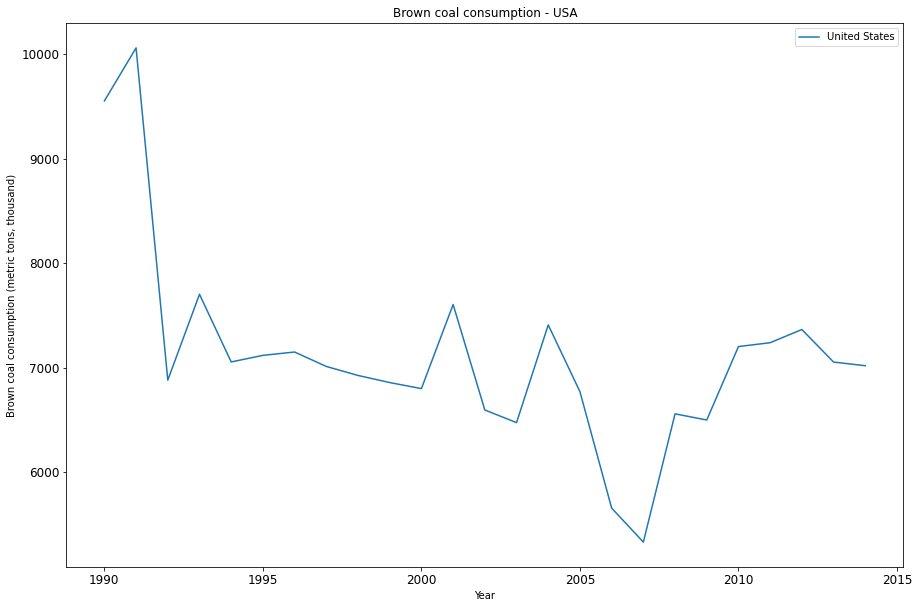

In [34]:
# plotting line graph for Coal consumption - USA

plt.figure(figsize=(15, 10))
x1 = coalconsumption_us.year
y1 = coalconsumption_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Brown coal consumption (metric tons, thousand)")
plt.title("Brown coal consumption - USA")
plt.legend(loc='best')
plt.show()

Natural Gas Consumption - USA

In [35]:
df1[df1.category.isin(['natural_gas_including_lng','natural_gas_liquids'])]

,country,commodity,year,unit,quantity,category
782190,albania,natural gas (including lng) - consumption by chemical and petrochemical,1996,terajoules,323.0,natural_gas_including_lng
782191,albania,natural gas (including lng) - consumption by chemical and petrochemical,1995,terajoules,389.0,natural_gas_including_lng
782192,albania,natural gas (including lng) - consumption by chemical and petrochemical,1994,terajoules,450.0,natural_gas_including_lng
782193,albania,natural gas (including lng) - consumption by chemical and petrochemical,1993,terajoules,500.0,natural_gas_including_lng
782194,albania,natural gas (including lng) - consumption by chemical and petrochemical,1992,terajoules,600.0,natural_gas_including_lng
...,...,...,...,...,...,...
854925,netherlands,natural gas liquids - transformation in petrochemical plants,1999,"metric tons, thousand",1508.0,natural_gas_liquids
854926,netherlands,natural gas liquids - transformation in petrochemical plants,1998,"metric tons, thousand",1362.0,natural_gas_liquids
854927,netherlands,natural gas liquids - transformation in petrochemical plants,1997,"metric tons, thousand",1333.0,natural_gas_liquids
854928,netherlands,natural gas liquids - transformation in petrochemical plants,1996,"metric tons, thousand",1259.0,natural_gas_liquids


In [36]:
gas_us = select_category(us_data, ['natural_gas_including_lng'])
gas_us

,country,commodity,year,unit,quantity,category
0,united states,natural gas (including lng) - transformation in electricity plants - main activity producers,1990,terajoules,3039619.0,natural_gas_including_lng
1,united states,natural gas (including lng) - own use by oil and gas extraction,1990,terajoules,1343653.0,natural_gas_including_lng
2,united states,natural gas (including lng) - consumption by households,1990,terajoules,4772284.0,natural_gas_including_lng
3,united states,"natural gas (including lng) - consumption by manufacturing, construction and non-fuel industry",1990,terajoules,5113334.0,natural_gas_including_lng
4,united states,natural gas (including lng) - consumption by other,1990,terajoules,7622534.0,natural_gas_including_lng
...,...,...,...,...,...,...
1072,united states,natural gas (including lng) - consumption by pipeline transport,2014,terajoules,910025.0,natural_gas_including_lng
1073,united states,natural gas (including lng) - consumption by textile and leather,2014,terajoules,45852.0,natural_gas_including_lng
1074,united states,natural gas (including lng) - consumption by transport,2014,terajoules,948328.0,natural_gas_including_lng
1075,united states,natural gas (including lng) - production,2014,terajoules,28026934.0,natural_gas_including_lng


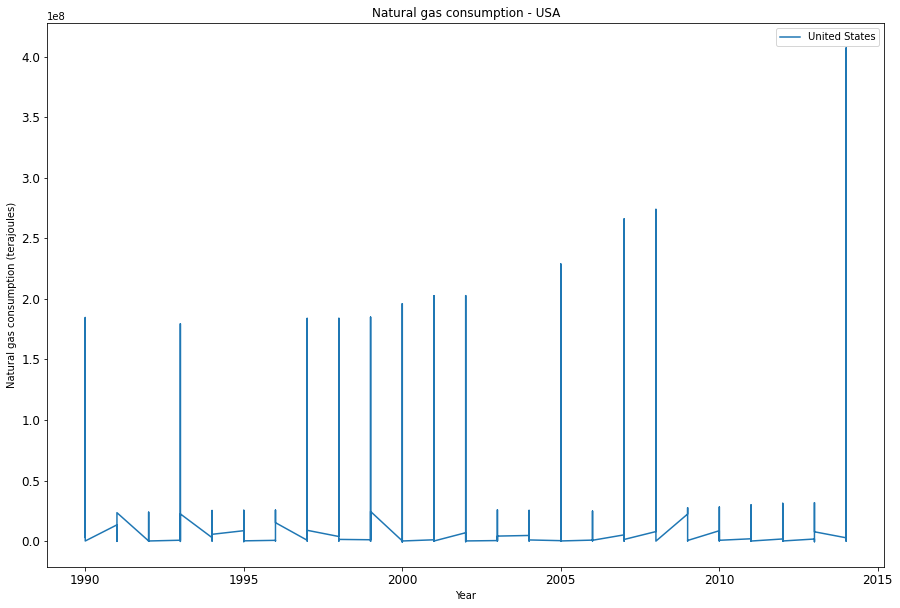

In [37]:
# plotting line graph for USA -  Natural gas consumption

plt.figure(figsize=(15, 10))
x1 = gas_us.year
y1 = gas_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Natural gas consumption (terajoules)")
plt.title("Natural gas consumption - USA")
plt.legend(loc='best')
plt.show()

Solar Energy Production - USA

In [38]:
# The Solar Electricity Consumption - USA

solar_us = select_category(us_data, ['solar_electricity'])

In [39]:
# To filter data for the Solar Electricity Production - USA

solarcap_us = select_commodity(solar_us,['electricity - total solar production'])

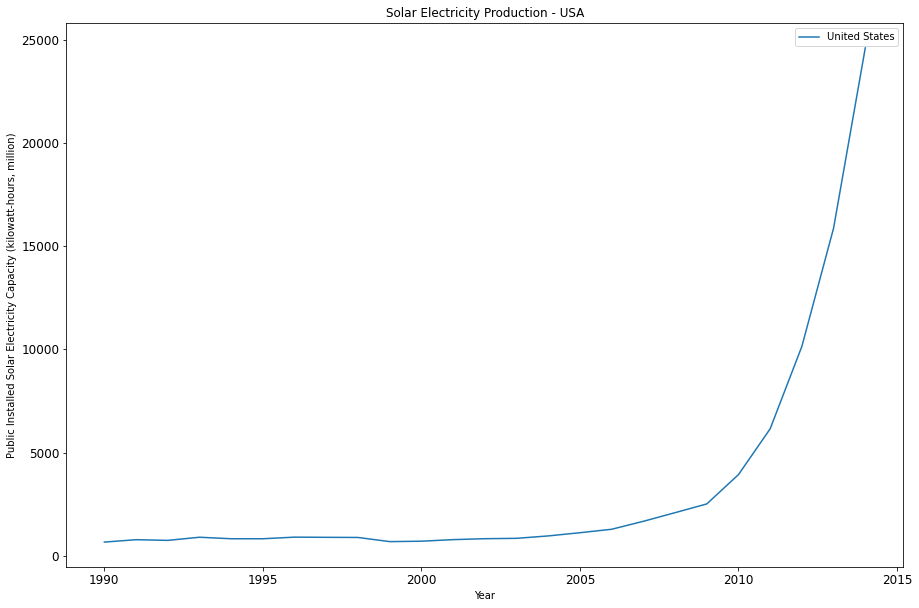

In [40]:
# To plot line graph for the Solar Electricity Production - USA

plt.figure(figsize=(15, 10))
x1 = solarcap_us.year
y1 = solarcap_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Public Installed Solar Electricity Capacity (kilowatt-hours, million)")
plt.title("Solar Electricity Production - USA")
plt.legend(loc='best')
plt.show()

In [41]:
# The Wind Electricity category - USA

wind_us = select_category(us_data, ['wind_electricity'])

In [42]:
# The Wind Electricity Production- USA

windcap_us = select_commodity(wind_us,['electricity - total wind production'])

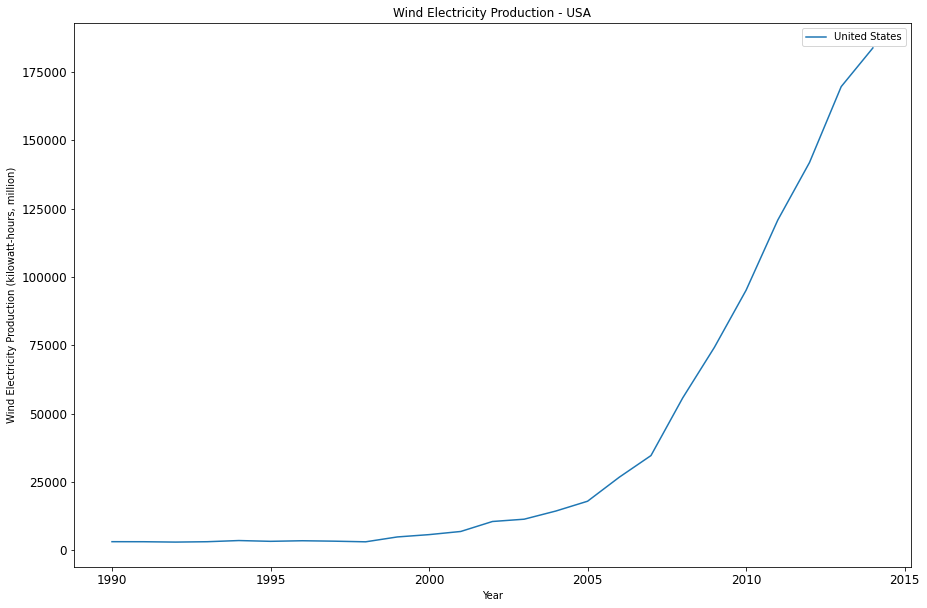

In [43]:
# To plot the line graph for the Wind Electricity Production - USA

plt.figure(figsize=(15, 10))
x1 = windcap_us.year
y1 = windcap_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Wind Electricity Production (kilowatt-hours, million)")
plt.title("Wind Electricity Production - USA")
plt.legend(loc='best')
plt.show()

Nuclear energy - USA

In [44]:
# The Nuclear Electricity category - USA
nuclear_us = select_category(us_data, ['nuclear_electricity'])

In [45]:
nuclear_us

,country,commodity,year,unit,quantity,category
0,united states,electricity - total nuclear production,1990,"kilowatt-hours, million",611589.0,nuclear_electricity
1,united states,electricity - total nuclear production,1991,"kilowatt-hours, million",649399.0,nuclear_electricity
2,united states,electricity - total nuclear production,1992,"kilowatt-hours, million",655970.0,nuclear_electricity
3,united states,electricity - total nuclear production,1993,"kilowatt-hours, million",646987.0,nuclear_electricity
4,united states,electricity - total nuclear production,1994,"kilowatt-hours, million",678920.0,nuclear_electricity
5,united states,electricity - total nuclear production,1995,"kilowatt-hours, million",713806.0,nuclear_electricity
6,united states,electricity - total nuclear production,1996,"kilowatt-hours, million",715212.0,nuclear_electricity
7,united states,electricity - total nuclear production,1997,"kilowatt-hours, million",666363.0,nuclear_electricity
8,united states,electricity - total nuclear production,1998,"kilowatt-hours, million",714124.0,nuclear_electricity
9,united states,electricity - total nuclear production,1999,"kilowatt-hours, million",771811.0,nuclear_electricity


In [46]:
# The Total Nuclear Electricity Production- USA

nuclearcap_us = select_commodity(nuclear_us,['electricity - total nuclear production'])

In [47]:
nuclearcap_us

,country,commodity,year,unit,quantity,category
0,united states,electricity - total nuclear production,1990,"kilowatt-hours, million",611589.0,nuclear_electricity
1,united states,electricity - total nuclear production,1991,"kilowatt-hours, million",649399.0,nuclear_electricity
2,united states,electricity - total nuclear production,1992,"kilowatt-hours, million",655970.0,nuclear_electricity
3,united states,electricity - total nuclear production,1993,"kilowatt-hours, million",646987.0,nuclear_electricity
4,united states,electricity - total nuclear production,1994,"kilowatt-hours, million",678920.0,nuclear_electricity
5,united states,electricity - total nuclear production,1995,"kilowatt-hours, million",713806.0,nuclear_electricity
6,united states,electricity - total nuclear production,1996,"kilowatt-hours, million",715212.0,nuclear_electricity
7,united states,electricity - total nuclear production,1997,"kilowatt-hours, million",666363.0,nuclear_electricity
8,united states,electricity - total nuclear production,1998,"kilowatt-hours, million",714124.0,nuclear_electricity
9,united states,electricity - total nuclear production,1999,"kilowatt-hours, million",771811.0,nuclear_electricity


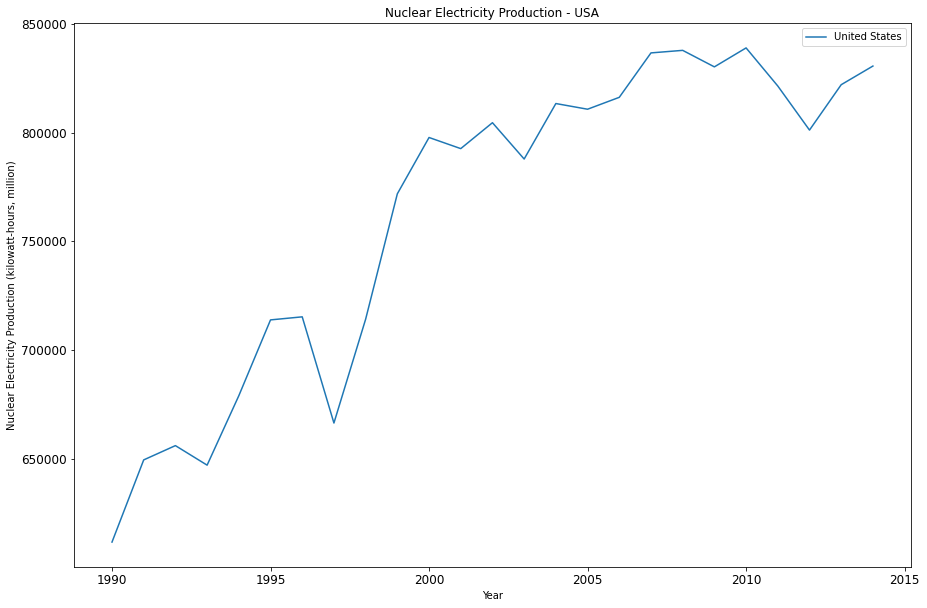

In [48]:
# To plot the line graph for the Nuclear Electricity Production - USA

plt.figure(figsize=(15, 10))
x1 = nuclearcap_us.year
y1 = nuclearcap_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Nuclear Electricity Production (kilowatt-hours, million)")
plt.title("Nuclear Electricity Production - USA")
plt.legend(loc='best')
plt.show()

Hydro Energy Production - USA

In [56]:
# The Hydro Electricity category - USA
hydro_us = select_category(us_data, ['hydro'])

In [57]:
hydro_us

,country,commodity,year,unit,quantity,category
0,united states,electricity - total hydro production,1990,"kilowatt-hours, million",288960.0,hydro
1,united states,electricity - total hydro production,1991,"kilowatt-hours, million",309155.0,hydro
2,united states,electricity - total hydro production,1992,"kilowatt-hours, million",274883.0,hydro
3,united states,electricity - total hydro production,1993,"kilowatt-hours, million",303060.0,hydro
4,united states,electricity - total hydro production,1994,"kilowatt-hours, million",284373.0,hydro
5,united states,electricity - total hydro production,1995,"kilowatt-hours, million",337856.0,hydro
6,united states,electricity - total hydro production,1996,"kilowatt-hours, million",376702.0,hydro
7,united states,electricity - total hydro production,1997,"kilowatt-hours, million",358685.0,hydro
8,united states,electricity - total hydro production,1998,"kilowatt-hours, million",322080.0,hydro
9,united states,electricity - total hydro production,1999,"kilowatt-hours, million",301793.0,hydro


In [51]:
# The Total Hydro Electricity Production- USA

hydrocap_us = select_commodity(hydro_us,['electricity - total hydro production'])

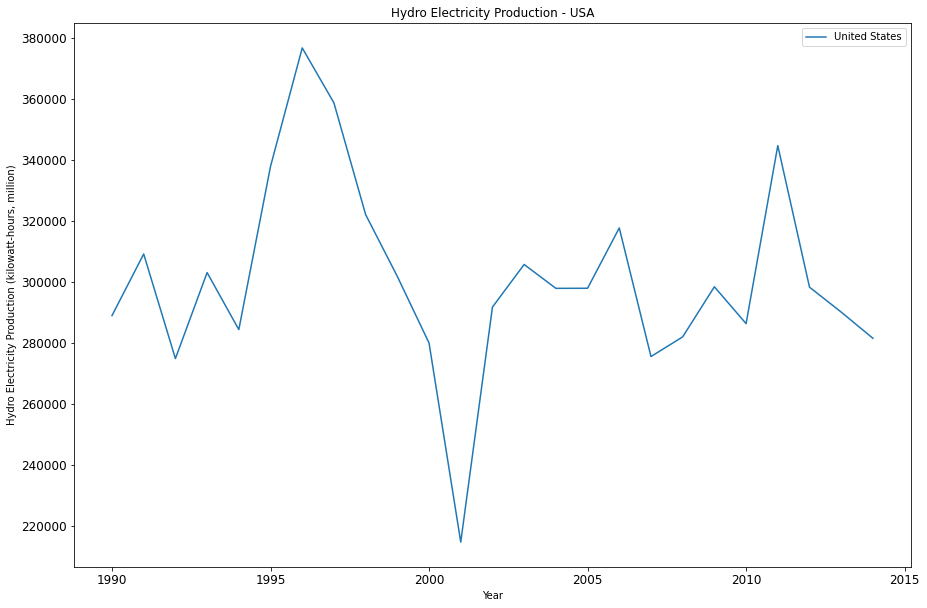

In [58]:
# To plot the line graph for the Hydro Electricity Production - USA

plt.figure(figsize=(15, 10))
x1 = hydrocap_us.year
y1 = hydrocap_us.quantity
plt.plot(x1, y1, label='United States')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year")
plt.ylabel("Hydro Electricity Production (kilowatt-hours, million)")
plt.title("Hydro Electricity Production - USA")
plt.legend(loc='best')
plt.show()

To conduct time series or linear regressional analysis on Coal Consumption - USA

In [59]:
coalconsumption_us.to_csv('usa_brown_coal.csv')

To apply time series analysis

In [60]:
df2 = pd.read_csv("usa_brown_coal.csv")
#pd.to_datetime(df.Year, format='%Y')
df2["year"] = pd.to_datetime(df2.year,format='%Y')
df2

,Unnamed: 0,country,commodity,year,unit,quantity,category
0,0,united states,brown coal - final energy consumption,1990-01-01,"metric tons, thousand",9551.0,brown_coal
1,1,united states,brown coal - final energy consumption,1991-01-01,"metric tons, thousand",10058.0,brown_coal
2,2,united states,brown coal - final energy consumption,1992-01-01,"metric tons, thousand",6882.0,brown_coal
3,3,united states,brown coal - final energy consumption,1993-01-01,"metric tons, thousand",7703.0,brown_coal
4,4,united states,brown coal - final energy consumption,1994-01-01,"metric tons, thousand",7056.0,brown_coal
5,5,united states,brown coal - final energy consumption,1995-01-01,"metric tons, thousand",7119.0,brown_coal
6,6,united states,brown coal - final energy consumption,1996-01-01,"metric tons, thousand",7151.0,brown_coal
7,7,united states,brown coal - final energy consumption,1997-01-01,"metric tons, thousand",7013.0,brown_coal
8,8,united states,brown coal - final energy consumption,1998-01-01,"metric tons, thousand",6927.0,brown_coal
9,9,united states,brown coal - final energy consumption,1999-01-01,"metric tons, thousand",6859.0,brown_coal
